In [88]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt

In [59]:
random_value = 42
random.seed(random_value)
np.random.seed(random_value)

In [138]:
class CreateSampleDataset():
    def __init__(self, n_teachers=1000, school_teacher_ratio=1.2, teacher_per_school=15.,
                 std_dev_teacher_per_school=3., min_teachers_per_school=5, p_rural=0.3, p_car=0.7, p_experienced=0.4):
        self.n_teachers = n_teachers
        self.n_schools = int(n_teachers * school_teacher_ratio / teacher_per_school)
        self.teacher_per_school = teacher_per_school
        self.std_dev_teacher_per_school = std_dev_teacher_per_school
        self.min_teachers_per_school = min_teachers_per_school
        self.p_rural = p_rural
        self.p_car = p_car
        self.p_experienced = p_experienced

    def _createTeachers(self):
        x_location = np.random.uniform(0., 1., self.n_teachers)
        y_location = np.random.uniform(0., 1., self.n_teachers)
        rural = np.random.choice([0, 1], p=[1 - self.p_rural, self.p_rural], size=self.n_teachers)
        car = np.random.choice([0, 1], p=[1 - self.p_car, self.p_car], size=self.n_teachers)
        experienced = np.random.choice([0, 1], p=[1 - self.p_experienced, self.p_experienced], size=self.n_teachers)
        teachers = {'x_location': x_location,
                    'y_location': y_location,
                    'rural': rural,
                    'car': car,
                    'experienced': experienced,
                    }

        return teachers

    def _createSchools(self):
        x_location = np.random.uniform(0., 1., self.n_schools)
        y_location = np.random.uniform(0., 1., self.n_schools)
        rural = np.random.choice([0, 1], p=[1 - self.p_rural, self.p_rural], size=self.n_schools)
        n_teachers = np.random.normal(loc=self.teacher_per_school, scale=self.std_dev_teacher_per_school, size=self.n_schools).astype(int)
        n_teachers_clipped = np.clip(n_teachers, a_min=self.min_teachers_per_school, a_max=None, out=n_teachers)
        schools = {'ID': range(self.n_schools),
                   'x_location': x_location,
                   'y_location': y_location,
                   'rural': rural,
                   'n_teachers': n_teachers_clipped,
                   }

        return schools

    def make_dataset(self):
        teachers = pd.DataFrame(self._createTeachers())
        schools = pd.DataFrame(self._createSchools())

        return teachers, schools

In [139]:
DatasetSampler = CreateSampleDataset()

In [140]:
teachers, schools = DatasetSampler.make_dataset()

In [141]:
teachers.head()

,x_location,y_location,rural,car,experienced
0,0.448085,0.768764,0,1,1
1,0.487900,0.265588,0,0,0
2,0.204256,0.767233,0,1,0
3,0.626803,0.205887,0,1,0
4,0.358743,0.321686,0,0,0


In [142]:
schools.head()

,ID,x_location,y_location,rural,n_teachers
0,0,0.100232,0.557066,1,13
1,1,0.932162,0.852956,1,19
2,2,0.374536,0.315056,0,12
3,3,0.080779,0.523672,0,16
4,4,0.387291,0.485372,1,19


In [143]:
from sklearn.neighbors import KNeighborsClassifier

In [144]:
def my_dist(x, y):
    return np.sum((x-y)**2)

In [145]:
knn = KNeighborsClassifier(n_neighbors=1, metric=my_dist)

In [146]:
X_train = np.array(schools[['x_location', 'y_location']])
y_train = np.array(schools['ID'])
knn.fit(X_train, y_train)

KNeighborsClassifier(metric=<function my_dist at 0x7f98110cf3a0>, n_neighbors=1)

In [147]:
X_test = np.array(teachers[['x_location', 'y_location']])
pred = knn.predict(X_test)
print(X_test.shape, pred.shape)

(1000, 2) (1000,)


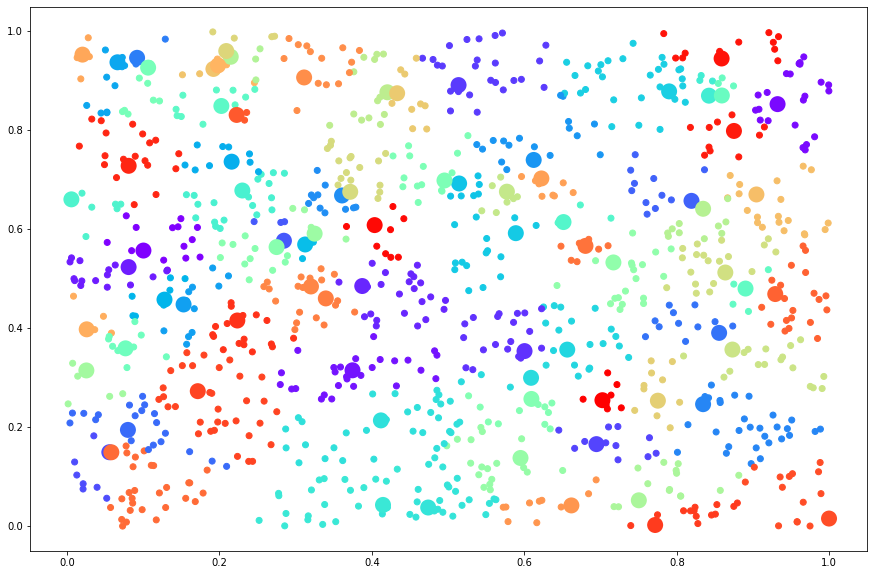

In [150]:
plt.figure(figsize=(15,10))
plt.scatter(X_test[:, 0], X_test[:, 1], c=pred, cmap='rainbow')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, linewidth=10., cmap='rainbow')